### Figure 2 supplementary

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy import plotting
from scipy import stats
from plotters import Plotter, get_nsd_vs_sd_df, add_zt_str
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

grpdata = subjects.GroupData()

### Firing rates in 1 hour blocks calculation (NOT plots)
See `sd_firing_dynamics.ipynb`.

### EDF3A: Firing rates WAKE

In [2]:
frate_df_sess = grpdata.frate_post_chunks_statewise
frate_df_sess

,grp,session,neuron_type,neuron_id,brainstate,zt,frate
0,NSD,0,inter,0,WK,PRE,4.660195
1,NSD,0,pyr,6,WK,PRE,0.484747
2,NSD,0,pyr,7,WK,PRE,0.070417
3,NSD,0,pyr,8,WK,PRE,0.014982
4,NSD,0,pyr,9,WK,PRE,0.034596
...,...,...,...,...,...,...,...
6671,SD,14,inter,90,NREM,ZT 5-7.5,0.708628
6672,SD,14,pyr,95,NREM,ZT 5-7.5,0.288952
6673,SD,14,inter,96,NREM,ZT 5-7.5,13.225728
6674,SD,14,pyr,97,NREM,ZT 5-7.5,0.927714


In [ ]:
# Compare old and new (after artifact bugfix) firing rates - why is IQR so much higher for NSD with new method vs. old?
frate_df = grpdata.frate_blocks_WK_bootstrap_session_neurons
frate_old_df = grpdata.frate_blocks_WK_bootstrap_session_neurons_bak

# Explicitly figure out why NS1 - NS2 is no longer significant
for frate_use in [frate_df, frate_old_df]:
    frate_nsd_pyr = frate_use[(frate_use.grp == "NSD") & (frate_use.neuron_type == "pyr")]
    frates0 = frate_nsd_pyr[frate_nsd_pyr.zt == "MAZE"].frate.values
    frates1 = frate_nsd_pyr[frate_nsd_pyr.zt == "ZT 0-2.5"].frate.values
    frates2 = frate_nsd_pyr[frate_nsd_pyr.zt == "ZT 2.5-5"].frate.values
    print(f"{np.sum(frates0 > frates1)/len(frates0)} {np.sum(frates1 > frates2)/len(frates1)} {np.sum(frates0 > frates2)/len(frates0)}")
frate_df.drop(columns="index").groupby(["grp", "neuron_type", "zt"]).quantile([0.25, 0.5, 0.75])

In [ ]:
# IQRs are almost identical - result is due to a small number of values at the edges of the distributions.
frate_old_df.groupby(["grp", "neuron_type", "zt"]).quantile([0.25, 0.5, 0.75])

In [ ]:
fig = subjects.SdFig().fig_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_WK_bootstrap_session_neurons
frate_df_sess = grpdata.frate_post_chunks_statewise
frate_df_sess = frate_df_sess[frate_df_sess.brainstate == "WK"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
# for i, ntype in enumerate(["pyr"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
    # for g, grp in enumerate(["NSD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{grp} {ntype} stats:\033[0m")
        plotter.boxplot_sd2(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob_paired, alpha_within=[0.025, 0.005, 0.0005], fontsize=5, verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.boxplot_sd2(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "firing_rate_within_WK", format="svg")

In [ ]:
ntype_df[ntype_df.grp == grp].groupby(["grp", "zt"]).quantile([0.25, 0.5, 0.75], numeric_only=True)

### EDF3C-D: Firing Rates QW vs AW


NSD pyr stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:2.282e-01 Stat=-1.241e-01
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:4.662e-01 Stat=6.479e-03
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:3.420e-02 Stat=2.265e-01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.599e-01 Stat=-1.032e-02
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:2.171e-01 Stat=-1.176e-01
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:5.740e-02 Stat=2.330e-01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.000e-02 Stat=2.162e-01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:2.138e-01 Stat=1.089e-01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:6.810e-02 Stat=2.227e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:2.372e-01 Stat=9.859e-02

SD pyr stats:


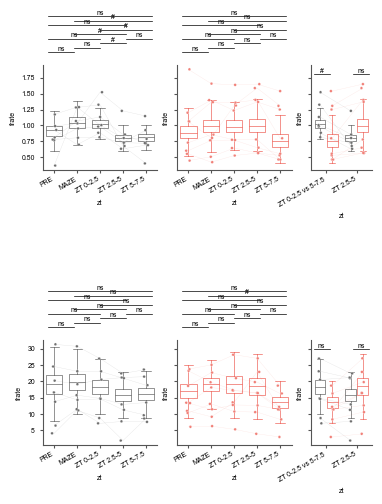

In [2]:
# QW first

fig = subjects.SdFig().fig_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_QW_bootstrap_session_neurons
frate_df_sess = grpdata.frate_post_chunks_qw_aw
frate_df_sess = frate_df_sess[frate_df_sess.brainstate == "QW"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
# for i, ntype in enumerate(["pyr"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
    # for g, grp in enumerate(["NSD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{grp} {ntype} stats:\033[0m")
        plotter.boxplot_sd2(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob_paired, alpha_within=[0.025, 0.005, 0.0005], fontsize=5, verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.boxplot_sd2(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "firing_rate_within_QW", format="svg")


NSD pyr stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:5.260e-02 Stat=-2.261e-01
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:4.149e-01 Stat=3.352e-02
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:7.670e-02 Stat=2.268e-01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.855e-01 Stat=-9.240e-03
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:9.070e-02 Stat=-1.926e-01
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:5.360e-02 Stat=2.603e-01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.062e-01 Stat=2.176e-01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:3.842e-01 Stat=3.424e-02
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:7.140e-02 Stat=2.511e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.165e-01 Stat=2.500e-02

SD pyr stats:


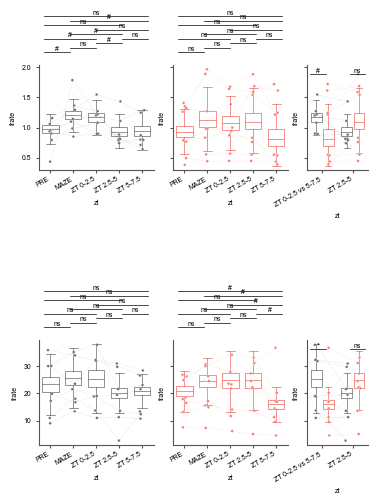

In [3]:
# AW next
fig = subjects.SdFig().fig_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_AW_bootstrap_session_neurons
frate_df_sess = grpdata.frate_post_chunks_qw_aw
frate_df_sess = frate_df_sess[frate_df_sess.brainstate == "AW"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
# for i, ntype in enumerate(["pyr"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
    # for g, grp in enumerate(["NSD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{grp} {ntype} stats:\033[0m")
        plotter.boxplot_sd2(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob_paired, alpha_within=[0.025, 0.005, 0.0005], fontsize=5, verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.boxplot_sd2(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "firing_rate_within_AW", format="svg")

### Firing rates QW with low vs high delta


NSD pyr stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:1.981e-01 Stat=-1.441e-01
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:3.737e-01 Stat=4.652e-02
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:7.020e-02 Stat=1.955e-01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.638e-01 Stat=-9.346e-03
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:2.813e-01 Stat=-9.755e-02
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:5.790e-02 Stat=2.420e-01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:7.580e-02 Stat=1.861e-01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:2.578e-01 Stat=9.791e-02
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:6.100e-02 Stat=2.326e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:2.778e-01 Stat=8.857e-02

SD pyr stats:


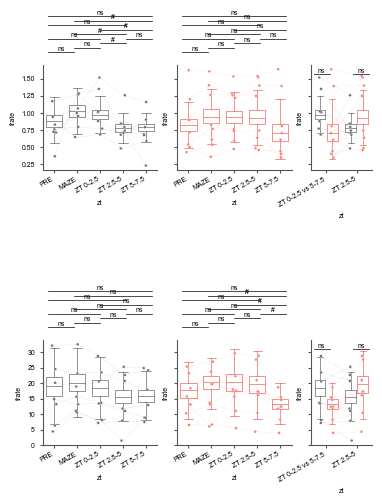

In [7]:
# QW low delta first

fig = subjects.SdFig().fig_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_QW_lowdelta_bootstrap_session_neurons
frate_df_sess = grpdata.frate_post_chunks_qw_delta_split_aw
frate_df_sess = frate_df_sess[frate_df_sess.brainstate == "QW_lowdelta"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
# for i, ntype in enumerate(["pyr"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
    # for g, grp in enumerate(["NSD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{grp} {ntype} stats:\033[0m")
        plotter.boxplot_sd2(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob_paired, alpha_within=[0.025, 0.005, 0.0005], fontsize=5, verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.boxplot_sd2(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "firing_rate_within_QWlowdelta", format="svg")


NSD pyr stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:3.165e-01 Stat=-6.585e-02
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:3.937e-01 Stat=3.244e-02
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:5.980e-02 Stat=1.655e-01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:3.429e-01 Stat=3.585e-02
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:4.227e-01 Stat=-3.341e-02
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:7.130e-02 Stat=1.980e-01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.130e-02 Stat=2.014e-01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.073e-01 Stat=1.321e-01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.870e-02 Stat=2.338e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:7.050e-02 Stat=1.679e-01

SD pyr stats:
p

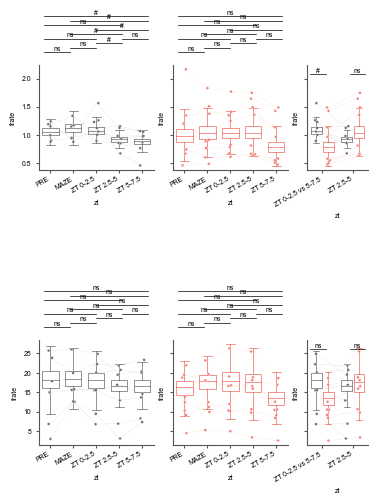

In [8]:
# QW high delta next

fig = subjects.SdFig().fig_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_QW_highdelta_bootstrap_session_neurons
frate_df_sess = grpdata.frate_post_chunks_qw_delta_split_aw
frate_df_sess = frate_df_sess[frate_df_sess.brainstate == "QW_highdelta"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
# for i, ntype in enumerate(["pyr"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
    # for g, grp in enumerate(["NSD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{grp} {ntype} stats:\033[0m")
        plotter.boxplot_sd2(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob_paired, alpha_within=[0.025, 0.005, 0.0005], fontsize=5, verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.boxplot_sd2(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "firing_rate_within_QWhighdelta", format="svg")

### EDF3E-F: QW vs AW firing rate distribution comparison

/tmp/ipykernel_2666131/2616645536.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(ytick)}}}$" for ytick in ax.get_yticks()])
/tmp/ipykernel_2666131/2616645536.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(ytick)}}}$" for ytick in ax.get_yticks()])


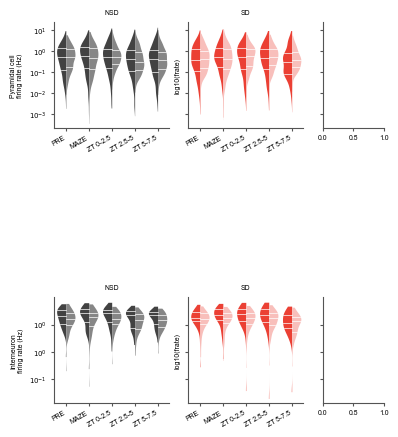

In [4]:
frate_df_sess = grpdata.frate_post_chunks_qw_aw
frate_df_sess = frate_df_sess[frate_df_sess["frate"] != 0]
frate_df_sess["log10(frate)"] = np.log10(frate_df_sess["frate"])
# frate_df_sess = frate_df_sess[~np.isinf(frate_df_sess["log10(frate)"])]

fig = subjects.SdFig().fig_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1.2)

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
# for i, ntype in enumerate(["pyr"]):
    ntype_df = frate_df_sess[frate_df_sess.neuron_type == ntype]
    # ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
    # for g, grp in enumerate(["NSD"]):
        # ax = fig.subplot(gs_[i, g])
        palette_use = [palette[g], palette_light[g]]
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="log10(frate)", hue="brainstate", ax=ax)
        plotter.violinplot_sd(palette=palette_use, split=True, legend='brief')
        ax.set_title(grp)
        ax.set_xlabel("")
        cell_str = "Pyramidal cell" if ntype == "pyr" else "Interneuron"
        if g == 0:
            ax.set_ylabel(f"{cell_str}\nfiring rate (Hz)")
            ax.set_yticklabels([f"$10^{{{int(ytick)}}}$" for ytick in ax.get_yticks()])

fig.savefig(subjects.figpath_sd / "firing_rate_dist_QWvAW", format="svg")
# Note that left/dark is AW and right/light is QW - see sanity check plot below.  Can't figure out why legend isn't plotting

In [78]:
frate_df_sess

,grp,session,neuron_type,neuron_id,brainstate,zt,frate,log10(frate)
0,NSD,0,inter,0,AW,PRE,6.493828,0.812501
1,NSD,0,pyr,6,AW,PRE,0.362805,-0.440327
2,NSD,0,pyr,7,AW,PRE,0.041571,-1.381205
4,NSD,0,pyr,9,AW,PRE,0.012849,-1.891119
5,NSD,0,pyr,10,AW,PRE,3.580052,0.553889
...,...,...,...,...,...,...,...,...
8485,SD,14,inter,90,QW,ZT 5-7.5,3.554974,0.550836
8486,SD,14,pyr,95,QW,ZT 5-7.5,0.243853,-0.612873
8487,SD,14,inter,96,QW,ZT 5-7.5,14.430797,1.159290
8488,SD,14,pyr,97,QW,ZT 5-7.5,0.585246,-0.232662


/tmp/ipykernel_1198782/619461773.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"$10^{{{int(ytick)}}}$" for ytick in ax.get_yticks()])


[Text(0, -4.0, '$10^{-4}$'),
 Text(0, -3.0, '$10^{-3}$'),
 Text(0, -2.0, '$10^{-2}$'),
 Text(0, -1.0, '$10^{-1}$'),
 Text(0, 0.0, '$10^{0}$'),
 Text(0, 1.0, '$10^{1}$'),
 Text(0, 2.0, '$10^{2}$')]

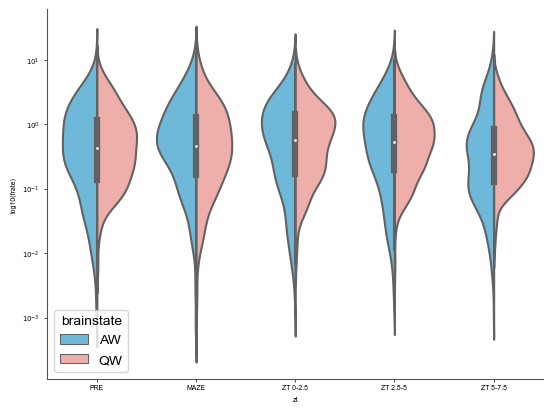

In [73]:
# Sanity check plot for legend.
_, ax = plt.subplots()
sns.violinplot(data=ntype_df[ntype_df.grp == grp], x="zt", y="log10(frate)", hue="brainstate", split=True,ax=ax)
ax.set_yticklabels([f"$10^{{{int(ytick)}}}$" for ytick in ax.get_yticks()])

#### Normality tests for EDF3E-F

In [30]:
boot_stat_df.drop(labels=["shapiro", "skew", "skew_pvalue", "iqr"], axis=1)

,shapiro_pvalue,zt,grp,neuron_type,brainstate
0,5.789874e-10,PRE,NSD,pyr,QW
1,9.854017e-07,MAZE,NSD,pyr,QW
2,6.532309e-03,ZT 0-2.5,NSD,pyr,QW
3,3.579917e-03,ZT 2.5-5,NSD,pyr,QW
4,1.721704e-03,ZT 5-7.5,NSD,pyr,QW
...,...,...,...,...,...
399995,1.192842e-06,PRE,SD,inter,AW
399996,5.704526e-05,MAZE,SD,inter,AW
399997,1.312332e-07,ZT 0-2.5,SD,inter,AW
399998,7.628442e-08,ZT 2.5-5,SD,inter,AW


In [37]:
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap_qw_aw
boot_stat_df = boot_stat_df[(boot_stat_df.neuron_type == "pyr") & (boot_stat_df.grp == "SD")]
alpha = 0.05
boot_prob_func = lambda x: np.sum(x > alpha)/len(x)
boot_stat_swp = (boot_stat_df.drop(labels=["shapiro", "skew", "skew_pvalue", "iqr", "neuron_type", "grp"], axis=1)
                .groupby(["zt", "brainstate"])
                .apply(boot_prob_func)
                .reset_index()
               )
boot_stat_swp.to_csv(subjects.GroupData().path / "shapiro_qw_aw_bootstrap_binary_pvalues.csv")
boot_stat_swp

,zt,brainstate,shapiro_pvalue
0,MAZE,AW,0.0092
1,MAZE,QW,0.0250
2,PRE,AW,0.0005
3,PRE,QW,0.0411
4,ZT 0-2.5,AW,0.0002
5,ZT 0-2.5,QW,0.0065
6,ZT 2.5-5,AW,0.0006
7,ZT 2.5-5,QW,0.0488
8,ZT 5-7.5,AW,0.0362
9,ZT 5-7.5,QW,0.1370


In [39]:
# Show for NSD too for reference
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap_qw_aw
boot_stat_df = boot_stat_df[(boot_stat_df.neuron_type == "pyr") & (boot_stat_df.grp == "NSD")]
alpha = 0.05
boot_prob_func = lambda x: np.sum(x > alpha)/len(x)
boot_stat_swp = (boot_stat_df.drop(labels=["shapiro", "skew", "skew_pvalue", "iqr", "neuron_type", "grp"], axis=1)
                .groupby(["zt", "brainstate"])
                .apply(boot_prob_func)
                .reset_index()
               )
# boot_stat_swp.to_csv(subjects.GroupData().path / "shapiro_qw_aw_bootstrap_binary_pvalues.csv")
boot_stat_swp

,zt,brainstate,shapiro_pvalue
0,MAZE,AW,0.0032
1,MAZE,QW,0.0218
2,PRE,AW,0.0001
3,PRE,QW,0.0072
4,ZT 0-2.5,AW,0.0012
5,ZT 0-2.5,QW,0.3752
6,ZT 2.5-5,AW,0.0013
7,ZT 2.5-5,QW,0.0287
8,ZT 5-7.5,AW,0.0006
9,ZT 5-7.5,QW,0.1189


In [28]:
boot_stat_df.drop(columns=["shapiro", "shapiro_pvalue", "skew", "skew_pvalue"]).groupby(["grp", "neuron_type", "zt"]).mean(numeric_only=True).reset_index()

,grp,neuron_type,zt,iqr
0,NSD,inter,MAZE,0.462956
1,NSD,inter,PRE,0.428638
2,NSD,inter,ZT 0-2.5,0.425911
3,NSD,inter,ZT 2.5-5,0.452149
4,NSD,inter,ZT 5-7.5,0.419634
5,NSD,pyr,MAZE,0.926741
6,NSD,pyr,PRE,0.898142
7,NSD,pyr,ZT 0-2.5,0.775304
8,NSD,pyr,ZT 2.5-5,0.886221
9,NSD,pyr,ZT 5-7.5,0.920975


### EDF3G: Log IQR plot for SD group AW vs QW

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:2.938e-01 Stat=7.144e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.719e-01 Stat=1.373e+00
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:7.089e-02 Stat=2.059e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:6.422e-02 Stat=2.182e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.793e-02 Stat=2.923e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.029e-02 Stat=3.357e+00


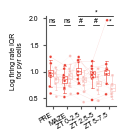

In [38]:
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap_qw_aw
boot_stat_df = boot_stat_df[boot_stat_df.grp == "SD"]
palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_stat_df = grpdata.frate_normality_statistic_blocks_pyr_only_qw_aw
frate_stat_df = frate_stat_df[frate_stat_df.grp == "SD"]

fig = subjects.SdFig().fig2_supp()

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1.2)

for n, ntype in enumerate(["pyr"]):
    df = boot_stat_df[boot_stat_df.neuron_type == ntype]
    df.loc[df.brainstate == "AW", "grp"] = "NSD"  # Fake assign NSD to all QW states for plotting purposes
    frate_stat_df.loc[frate_stat_df.brainstate == "AW", "grp"] = "NSD"
    ax = fig.subplot(fig.gs[n])
    p1 = Plotter(
        data=df,
        x="zt",
        y="iqr",
        hue="grp",
        hue_order=["NSD", "SD"],
        ax=ax,
    )
    # ax.axhline(0.05, lw=0.5)
    # p1.plot_kw['fill'] = False
    # p1.boxplot_sd(palette=subjects.colors_sd(), box_fill=False)
    # p1.boxplot_sd2(palette=palette)
    p1.boxplot_sd2(palette=[palette[1], palette_light[1]])
    p1.stat_anot_sd(stat_across=get_bootstrap_prob, alpha_across=[0.05, 0.01, 0.001], fontsize=5, verbose=True)

    p2 = Plotter(data=frate_stat_df, x="zt", y="iqr", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    # p2.striplineplot_sd(palette=palette_light)
    p2.striplineplot_sd(palette=[palette[1], palette_light[1]])
    # ax.set_yscale("log")
    ax.set_ylabel("Log firing rate IQR\n for pyr cells")
    ax.set_xlabel("")
    # ax.set_ylim((0.375, 1.7))

# fig.savefig(subjects.figpath_sd / "frate_normality_tests", format="pdf")
fig.savefig(subjects.figpath_sd / "frate_normality_tests_pyr_only_qw_aw", format="svg")

### EDF3G - IQR for QW vs AW

### EDF3Firing rates NREM

In [ ]:
frate_df_sess.groupby(["session", "neuron_type"]).mean()

In [ ]:
from copy import deepcopy
fig = subjects.SdFig().fig_supp()

# Session 13 is wreaking havoc on things due to an abnormally high firing rate during PRE/NREM (RatUDay4SD)
# (this occurs because session 13 actually has the tiniest sliver of NREM during which there was some firing, resulting in an
# artifically high firing rate because the total time in NREM is close to zero...)
drop_session13pre = False
save_append = "_dropsession13" if drop_session13pre else ""

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = getattr(grpdata, f"frate_blocks_NREM_bootstrap_session_neurons{save_append}")
frate_df_sess = grpdata.frate_post_chunks_statewise
frate_df_sess = frate_df_sess[frate_df_sess.brainstate == "NREM"]
# if exclude_pre:
#     frate_df = frate_df[frate_df.zt != "PRE"]
#     frate_df_sess = frate_df_sess[frate_df_sess.zt != "PRE"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)
if drop_session13pre:
    frate_sess_mean.loc[(frate_sess_mean.session == 13), "frate"] = np.nan

gs_ = fig.subplot2grid(
    fig.gs[2:4, :4], grid=(2, 3), width_ratios=[1.5, 1.5, 0.8], hspace=0.2, wspace=0.3
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_df = ntype_df[ntype_df.zt != "MAZE"]
    ntype_df2 = deepcopy(ntype_df)
    ntype_df2["zt"] = pd.Categorical(ntype_df2["zt"], ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"])
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    ntype_mean_df = ntype_mean_df[ntype_mean_df != "MAZE"]
    ntype_mean_df2 = deepcopy(ntype_mean_df)
    ntype_mean_df2["zt"] = pd.Categorical(ntype_mean_df2["zt"], ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"])
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        print(f"\n\033[4m{grp} {ntype} stats:\033[0m")
        plotter = Plotter(data=ntype_df2[ntype_df2.grp == grp], x="zt", y="frate", ax=ax)
        plotter.boxplot_sd2(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob, alpha_within=[0.025, 0.005, 0.0005], fontsize=5, verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df2[ntype_mean_df2.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.boxplot_sd2(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.001, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / f"firing_rate_within_NREM{save_append}", format="svg")

In [ ]:
# Figure out which sessions have enough NREM during SD2 to calculate firing rates.
ntype_mean_df[(ntype_mean_df.grp == "SD") & (ntype_mean_df.zt == "ZT 2.5-5")]

### 2D: Normality tests for firing rate - IQR plots

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:2.198e-01 Stat=1.153e+00
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:4.986e-01 Stat=3.621e-02
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:2.579e-03 Stat=4.289e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:1.458e-02 Stat=3.034e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:4.361e-01 Stat=2.941e-01
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:3.948e-01 Stat=3.125e-01


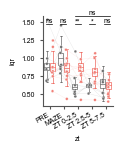

In [5]:
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap
palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_stat_df = grpdata.frate_normality_statistic_blocks_pyr_only

fig = subjects.SdFig().fig2_supp()

for n, ntype in enumerate(["pyr"]):
    df = boot_stat_df[boot_stat_df.neuron_type == ntype]
    ax = fig.subplot(fig.gs[n])
    p1 = Plotter(
        data=df,
        x="zt",
        y="iqr",
        hue="grp",
        hue_order=["NSD", "SD"],
        ax=ax,
    )
    # ax.axhline(0.05, lw=0.5)
    # p1.plot_kw['fill'] = False
    # p1.boxplot_sd(palette=subjects.colors_sd(), box_fill=False)
    p1.boxplot_sd2(palette=palette)
    p1.stat_anot_sd(stat_across=get_bootstrap_prob, alpha_across=[0.05, 0.01, 0.001], fontsize=5, verbose=True)

    p2 = Plotter(data=frate_stat_df, x="zt", y="iqr", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_yscale("log")

# fig.savefig(subjects.figpath_sd / "frate_normality_tests", format="pdf")
fig.savefig(subjects.figpath_sd / "frate_normality_tests_pyr_only", format="pdf")

In [7]:
frate_stat_df.groupby(["grp", "zt"]).mean(numeric_only=True)

session  level_2   shapiro  shapiro_pvalue      skew  \
grp zt                                                               
NSD MAZE          3.0      1.0  0.954823        0.338680 -1.929820   
    PRE           3.0      0.0  0.960600        0.320330 -0.938648   
    ZT 0-2.5      3.0      2.0  0.969716        0.437179 -0.045309   
    ZT 2.5-5      3.0      3.0  0.971873        0.424894 -0.031075   
    ZT 5-7.5      3.0      4.0  0.970902        0.395591  0.070006   
SD  MAZE         10.5      1.0  0.943296        0.212104 -1.762011   
    PRE          10.5      0.0  0.943337        0.153734 -0.659968   
    ZT 0-2.5     10.5      2.0  0.953440        0.247651 -1.120433   
    ZT 2.5-5     10.5      3.0  0.957557        0.292291 -0.763385   
    ZT 5-7.5     10.5      4.0  0.968249        0.546842 -0.169825   

              skew_pvalue       iqr  
grp zt                               
NSD MAZE         0.336575  1.013379  
    PRE          0.479149  0.909739  
    ZT 0-2.5     0.612942  0.637681  
    ZT 2.5-5     0.421894  0.601843  
    ZT 5-7.5     0.491772  0.589181  
SD  MAZE         0.229700  0.829939  
    PRE          0.396639  0.881400  
    ZT 0-2.5     0.310991  0.775135  
    ZT 2.5-5     0.448476  0.782775  
    ZT 5-7.5     0.451818  0.575709

In [ ]:
# Get n for all comparisons.
frate_stat_df.groupby(["grp", "zt"]).count()

#### Same as above but statewise (NREM vs WAKE)

In [ ]:
boot_stat_df

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.395e-01 Stat=6.331e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:4.550e-01 Stat=1.160e-01
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:3.286e-02 Stat=2.584e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:3.168e-01 Stat=7.234e-01
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.987e-01 Stat=1.227e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:4.191e-01 Stat=3.249e-01


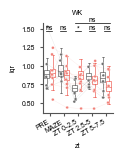

In [14]:
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap_statewise
palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_stat_df = grpdata.frate_normality_statistic_blocks_pyr_only_statewise

fig = subjects.SdFig().fig2_supp()

for st, state in enumerate(["WK"]):
    for n, ntype in enumerate(["pyr"]):
        df = boot_stat_df[(boot_stat_df.neuron_type == ntype) & (boot_stat_df.brainstate == state)]
        state_df = frate_stat_df[frate_stat_df.brainstate == state]
        ax = fig.subplot(fig.gs[ids])
        p1 = Plotter(
            data=df,
            x="zt",
            y="iqr",
            hue="grp",
            hue_order=["NSD", "SD"],
            ax=ax,
        )
        # ax.axhline(0.05, lw=0.5)
        # p1.plot_kw['fill'] = False
        # p1.boxplot_sd(palette=subjects.colors_sd(), box_fill=False)
        p1.boxplot_sd2(palette=palette)
        p1.stat_anot_sd(stat_across=get_bootstrap_prob, alpha_across=[0.05, 0.01, 0.001], fontsize=5, verbose=True)
    
        p2 = Plotter(data=state_df, x="zt", y="iqr", hue="grp", hue_order=["NSD", "SD"], ax=ax)
        p2.striplineplot_sd(palette=palette_light)
        ax.set_title(state)
        # ax.set_yscale("log")

fig.savefig(subjects.figpath_sd / "frate_normality_tests_pyr_only_statewise", format="pdf")

## Firing Rate Distributions by state (NREM vs WAKE)
p-values from p(Shapiro-Wilk < 0.05) from bootstrapped distributions.

In [5]:
frate_df_sess

,grp,session,neuron_type,neuron_id,brainstate,zt,frate
0,NSD,0,inter,0,WK,PRE,4.660195
1,NSD,0,pyr,6,WK,PRE,0.484747
2,NSD,0,pyr,7,WK,PRE,0.070417
3,NSD,0,pyr,8,WK,PRE,0.014982
4,NSD,0,pyr,9,WK,PRE,0.034596
...,...,...,...,...,...,...,...
6671,SD,14,inter,90,NREM,ZT 5-7.5,0.708628
6672,SD,14,pyr,95,NREM,ZT 5-7.5,0.288952
6673,SD,14,inter,96,NREM,ZT 5-7.5,13.225728
6674,SD,14,pyr,97,NREM,ZT 5-7.5,0.927714


,brainstate,neuron_type,zt,grp,shapiro_pvalue
0,NREM,inter,MAZE,NSD,1.0000
1,NREM,inter,MAZE,SD,1.0000
2,NREM,inter,PRE,NSD,0.9088
3,NREM,inter,PRE,SD,0.9999
4,NREM,inter,ZT 0-2.5,NSD,0.0559
5,NREM,inter,ZT 0-2.5,SD,1.0000
6,NREM,inter,ZT 2.5-5,NSD,0.0401
7,NREM,inter,ZT 2.5-5,SD,1.0000
8,NREM,inter,ZT 5-7.5,NSD,0.0231
9,NREM,inter,ZT 5-7.5,SD,0.1235


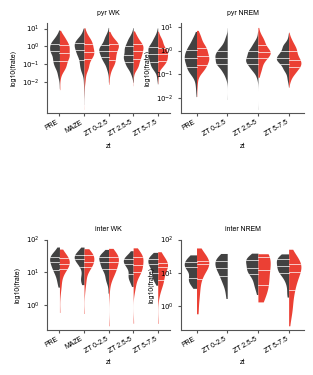

In [2]:
fig = subjects.SdFig().fig2()

palette = subjects.colors_sd(1)

boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap_statewise
boot_stat_df = add_zt_str(boot_stat_df)
frate_df_sess = grpdata.frate_post_chunks_statewise
frate_df_sess = frate_df_sess.loc[(frate_df_sess!=0).all(axis=1)] # Drop any cells that have a 0 firing rate at any point
frate_df_sess.insert(6, "log10(frate)", np.log10(frate_df_sess.frate.values))
frate_df_sess = add_zt_str(frate_df_sess)
fig2_ylims_ticks = [(-3.3, 1.2), (-0.7, 2.1)], [(-2, -1, 0, 1), (0, 1, 2)]
figs2_ylims_ticks = [(-3.8, 2.05), (-1.05, 2.5)], [(-2, 0, 2), (-1, 0, 1, 2)]
ylims_ticks_use = fig2_ylims_ticks

for ids, st in enumerate(["WK", "NREM"]):
    for idn, (ntype, ylims, yticks) in enumerate(zip(["pyr", "inter"], ylims_ticks_use[0], ylims_ticks_use[1])):
        [(-3.3, 1.2), (-0.7, 2.1)], [(-2, -1, 0, 1), (0, 1, 2)]
        ntype_df = frate_df_sess[(frate_df_sess.neuron_type == ntype) & (frate_df_sess.brainstate == st)]
        
        ax = fig.subplot(fig.gs[idn*2, (2 * ids):(2 * (ids + 1))])
        
        plotter = Plotter(data=ntype_df, x="zt", y="log10(frate)", hue="grp", ax=ax)
        plotter.violinplot_sd(split=True, palette=palette).stat_anot_sd(
            stat_across=None,
            alpha_across=[0.05, 0.01, 0.005],
            fontsize=5,
        )
        ax.set_title(f"{ntype} {st}")
        # ax.set_ylim(ylims)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"$10^{{{ytick}}}$" for ytick in yticks])

# Calculate probabilities and add by hand to plots.  See block at bottom for p-value calculation logic.
alpha = 0.05
boot_prob_func = lambda x: np.sum(x > alpha)/len(x)
skew_prob_func = lambda x: np.sum(x)/len(x)
skew_stat_df = (boot_stat_df.drop(labels=["shapiro", "shapiro_pvalue", "iqr"], axis=1)
                .groupby(["brainstate", "neuron_type", "zt", "grp"])
                .apply(skew_prob_func)
                .reset_index()
               )
boot_stat_swp = (boot_stat_df.drop(labels=["shapiro", "skew", "skew_pvalue", "iqr"], axis=1)
                .groupby(["brainstate", "neuron_type", "zt", "grp"])
                .apply(boot_prob_func)
                .reset_index()
               )
boot_stat_swp.to_csv(subjects.GroupData().path / "shapiro_bootstrap_binary_pvalues_statewise.csv")

fig.savefig(subjects.figpath_sd / "fig2_frate_dist_statewise.pdf")
fig.savefig(subjects.figpath_sd / "fig2_frate_dist_statewise", format="svg")
boot_stat_swp

In [4]:
boot_stat_df.groupby

,shapiro,shapiro_pvalue,skew,skew_pvalue,iqr,zt,grp,neuron_type,brainstate
0,0.977917,0.000662,-2.697400,0.006988,1.012240,PRE,NSD,pyr,WK
1,0.959899,0.000002,-3.503726,0.000459,1.139247,MAZE,NSD,pyr,WK
2,0.990785,0.119399,-1.908377,0.056343,0.751536,ZT 0-2.5,NSD,pyr,WK
3,0.985321,0.011886,-0.349659,0.726595,0.888181,ZT 2.5-5,NSD,pyr,WK
4,0.989518,0.069756,-0.320058,0.748924,0.990026,ZT 5-7.5,NSD,pyr,WK
...,...,...,...,...,...,...,...,...,...
399995,NaN,1.000000,NaN,NaN,NaN,PRE,SD,inter,NREM
399996,NaN,1.000000,NaN,NaN,NaN,MAZE,SD,inter,NREM
399997,NaN,1.000000,NaN,NaN,NaN,ZT 0-2.5,SD,inter,NREM
399998,NaN,1.000000,NaN,NaN,NaN,ZT 2.5-5,SD,inter,NREM


### Same as above but within ripples only

In [69]:
t = []
x = (1, 2)
t.append([*x])
t

[[1, 2]]

In [73]:
# Function to calculate normality stats for individual sessions
def func(df):
    columns = ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"]
    statistic = []
    for col in columns:
        # try:
        #     shapiro_stats = stats.shapiro(np.log10(df.loc[:, col].values))
        # except ValueError:
        #     shapiro_stats = (np.nan, np.nan)
        #     stats.skewtest(np.log10(df.loc[:, col].values))
        # try:
        if len(df.loc[:, col].values) >= 8:
            statistic.append(
                [
                    *stats.shapiro(np.log10(df.loc[:, col].values)),
                    *stats.skewtest(np.log10(df.loc[:, col].values)),
                    # stats.kurtosistest(np.log10(df.loc[:, col]))[0], # Warning for n<=20
                    # stats.normaltest(np.log10(df.loc[:, col]))[0], # warning for n<=20
                    stats.iqr(np.log10(df.loc[:, col].values)),
                ]
            )
        elif len(df.loc[:, col].values) >= 3:
            statistic.append(
                [
                    *stats.shapiro(np.log10(df.loc[:, col].values)),
                    *(np.nan, np.nan),
                    # stats.kurtosistest(np.log10(df.loc[:, col]))[0], # Warning for n<=20
                    # stats.normaltest(np.log10(df.loc[:, col]))[0], # warning for n<=20
                    stats.iqr(np.log10(df.loc[:, col].values)),
                ]
            )
        else:
            statistic.append([np.nan, np.nan, np.nan, np.nan, np.nan])
            
        # try:
        #     statistic.append(
        #         [
        #             *stats.shapiro(np.log10(df.loc[:, col].values)),
        #             *stats.skewtest(np.log10(df.loc[:, col].values)),
        #             # stats.kurtosistest(np.log10(df.loc[:, col]))[0], # Warning for n<=20
        #             # stats.normaltest(np.log10(df.loc[:, col]))[0], # warning for n<=20
        #             stats.iqr(np.log10(df.loc[:, col].values)),
        #         ]
        #     )
        # except ValueError:
        #     try:
            #     statistic.append(
            #     [
            #         *stats.shapiro(np.log10(df.loc[:, col].values)),
            #         *stats.skewtest(np.log10(df.loc[:, col].values)),
            #         # stats.kurtosistest(np.log10(df.loc[:, col]))[0], # Warning for n<=20
            #         # stats.normaltest(np.log10(df.loc[:, col]))[0], # warning for n<=20
            #         stats.iqr(np.log10(df.loc[:, col].values)),
            #     ]
            # )
            # statistic.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    statistic = np.array(statistic)
    stat_df = pd.DataFrame(
        statistic, columns=["shapiro", "shapiro_pvalue", "skew", "skew_pvalue", "iqr"]
    )
    stat_df["zt"] = columns
    return stat_df

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:4.084e-01 Stat=3.045e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.055e-01 Stat=1.733e+00
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:1.182e-01 Stat=1.609e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:3.753e-02 Stat=2.469e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.301e-01 Stat=1.566e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.709e-01 Stat=1.340e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:4.989e-01 Stat=6.466e-02
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:3.342e-01 Stat=6.668e-01
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:4.003e-01 Stat=3.5

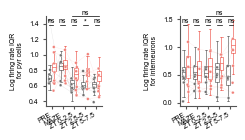

<Figure size 850x1100 with 0 Axes>

In [74]:
fig = subjects.SdFig().fig2()

palette = subjects.colors_sd(1)

boot_stat_df = grpdata.frate_win_ripple_normality_statistic_blocks_bootstrap
boot_stat_df = add_zt_str(boot_stat_df)

frate_rip_df = subjects.GroupData().frate_in_ripple
frate_rip_df = frate_rip_df[frate_rip_df["where"] == "inside"]
frate_rip_df = frate_rip_df.loc[(frate_rip_df!=0).all(axis=1)] # Drop any cells that have a 0 firing rate at any point
frate_rip_df = (
    frate_rip_df.pivot_table(
        columns=["zt"],
        values=["frate"],
        index=["grp", "session", "neuron_id", "neuron_type"],
        sort=False,
    )
    .reset_index(col_level=1)
    .droplevel(0, axis=1)
    .drop(["neuron_id"], axis=1)
)
frate_stat_df = frate_rip_df.groupby(["grp", "session", "neuron_type"]).apply(func).reset_index()

fig2_ylims_ticks = [(-3.3, 1.2), (-0.7, 2.1)], [(-2, -1, 0, 1), (0, 1, 2)]
figs2_ylims_ticks = [(-3.8, 2.05), (-1.05, 2.5)], [(-2, 0, 2), (-1, 0, 1, 2)]
ylims_ticks_use = fig2_ylims_ticks

ig = subjects.SdFig().fig2_supp()

for n, ntype in enumerate(["pyr", "inter"]):
    df = boot_stat_df[boot_stat_df.neuron_type == ntype]
    ax = fig.subplot(fig.gs[n*2])
    p1 = Plotter(
        data=df,
        x="zt",
        y="iqr",
        hue="grp",
        hue_order=["NSD", "SD"],
        ax=ax,
    )
    # ax.axhline(0.05, lw=0.5)
    # p1.plot_kw['fill'] = False
    # p1.boxplot_sd(palette=subjects.colors_sd(), box_fill=False)
    p1.boxplot_sd2(palette=palette)
    p1.stat_anot_sd(stat_across=get_bootstrap_prob, alpha_across=[0.05, 0.01, 0.001], fontsize=5, verbose=True)

    p2 = Plotter(data=frate_stat_df[frate_stat_df.neuron_type == ntype], x="zt", y="iqr", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    cell_str = "pyr cells" if ntype == "pyr" else "interneurons"
    ax.set_ylabel(f"Log firing rate IQR\n for {cell_str}")
    ax.set_xlabel("")
    # ax.set_yscale("log")

fig.savefig(subjects.figpath_sd / "frate_log_iqr_win_ripples", format="svg")

In [75]:
frate_stat_df[frate_stat_df.neuron_type == "inter"].groupby(["grp", "session"]).count()

neuron_type  level_3  shapiro  shapiro_pvalue  skew  skew_pvalue  \
grp session                                                                     
NSD 1                  5        5        5               5     5            5   
    2                  5        5        5               5     5            5   
    3                  5        5        0               0     0            0   
    4                  5        5        5               5     5            5   
    5                  5        5        5               5     0            0   
    6                  5        5        5               5     0            0   
SD  8                  5        5        0               0     0            0   
    9                  5        5        5               5     5            5   
    10                 5        5        5               5     0            0   
    11                 5        5        5               5     0            0   
    12                 5        5        5               5     0            0   
    13                 5        5        5               5     5            5   
    14                 5        5        5               5     0            0   

             iqr  zt  
grp session           
NSD 1          5   5  
    2          5   5  
    3          0   5  
    4          5   5  
    5          5   5  
    6          5   5  
SD  8          0   5  
    9          5   5  
    10         5   5  
    11         5   5  
    12         5   5  
    13         5   5  
    14         5   5

In [66]:
stats.skewtest([0, 1, 2])

ValueError: skewtest is not valid with less than 8 samples; 3 samples were given.